1.)  Import needed libraries and data to be used


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

df = pd.read_csv("driver_data.csv")
df.head()

,Distance_Feature,Speeding_Feature
0,71.24,28
1,52.53,25
2,64.54,27
3,55.69,22
4,54.58,25


2.)  Need to first standardize the data

In [5]:
std_scale = StandardScaler().fit(df)
df_scaled = std_scale.transform(df)
df_scaled[:5,]


C:\Users\Todd\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Todd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


array([[-0.0898104 ,  1.26061251],
       [-0.43977285,  1.04174351],
       [-0.215131  ,  1.18765617],
       [-0.38066642,  0.8228745 ],
       [-0.40142849,  1.04174351]])

3.)  Now run multiple iterations of KMeans algorithm to find the optimal number of clusters using elbow method.  Once we do this, we'll make a Scree plot to view this.

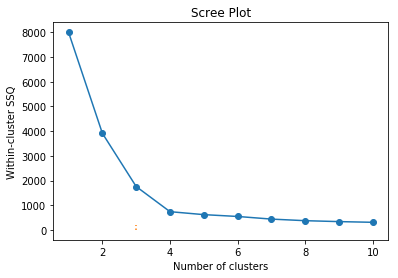

In [6]:
ssq = []

for K in range(1,11):
    kmeans_model = KMeans(n_clusters=K, random_state=123)
    kmeans_model.fit(df_scaled)
    ssq.append(kmeans_model.inertia_)
    
plt.plot(range(1,11), ssq, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Within-cluster SSQ")
plt.title("Scree Plot")
plt.plot([3]*200, range(1,201), ":")
plt.show()

From the chart above it looks like the "elbow" point is at Number of Clusters = 4.  This should be the optimal number.

4.)  Assuming 4 clusters, we'll fit a KMeans model, and make predictions for the clusters of the dataset.

In [7]:
km = KMeans(n_clusters=4, random_state=123)
km.fit(df_scaled)
predicted_cluster = km.predict(df_scaled)



Before plotting these, it might be easier to 'de-scale' these to make the centroids of each cluster make more meaningful sense.  So will create a new field in our dataset for this and print the coordinates of the centroids out.

In [8]:
df['km_cluster'] = predicted_cluster
df.groupby('km_cluster')['Distance_Feature','Speeding_Feature'].mean()


,Distance_Feature,Speeding_Feature
km_cluster,,
0,50.016637,5.204037
1,177.835096,70.288462
2,180.434863,10.529496
3,50.404824,32.365340


Now let's plot the clusters

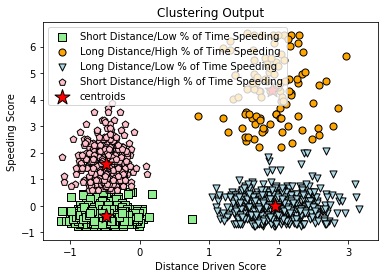

In [9]:
plt.scatter(df_scaled[predicted_cluster==0,0], df_scaled[predicted_cluster==0, 1], s=50, c='lightgreen',\
           marker='s', edgecolors='black', label='Short Distance/Low % of Time Speeding')
plt.scatter(df_scaled[predicted_cluster==1,0], df_scaled[predicted_cluster==1, 1], s=50, c='orange',\
           marker='o', edgecolors='black', label='Long Distance/High % of Time Speeding')
plt.scatter(df_scaled[predicted_cluster==2,0], df_scaled[predicted_cluster==2, 1], s=50, c='lightblue',\
           marker='v', edgecolors='black', label='Long Distance/Low % of Time Speeding')
plt.scatter(df_scaled[predicted_cluster==3,0], df_scaled[predicted_cluster==3, 1], s=50, c='pink',\
           marker='p', edgecolors='black', label='Short Distance/High % of Time Speeding')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, c='red',\
           marker='*', edgecolors='black', label='centroids')
plt.legend(scatterpoints=1)
plt.xlabel("Distance Driven Score")
plt.ylabel("Speeding Score")
plt.title("Clustering Output")
plt.show()

(Note:  After initially viewing the clusters, I renamed the categories of the cluster to be more meaningful.)

In looking at the cluster chart, a few observations:

-The 4 groups make sense intuitively (I relabeled the clusters as such into low/high Distance/% of time speeding combinations.)

-What's interesting is no matter the distance traveled, the 'low % of time speeding is about the same between the two groups (with the averages being 5% and 10% speeding respectively).

-However, the 'high % of time speeding' for the 'Long Distance' grouping is much more extreme than with 'Short Distance' (with an average value of 70% vs 32%).  

-For the 'Long Distance/High % of Time Speeding' group, this might make sense in that if a person is traveling a long distance and really wants to cut down on the time (given that the time is probably very long) they might be more prone to speeding. They may also might be travelling more on long major highways vs the ones driving a short distance, which might give them more opportunities to drive over the speed limit for long stretches.

-This might be insightful to things such as insurance rates for long distance groupings.



5.)  Next, will perform an agglomerative clustering on this dataset.  First, will plot a dendrogram.

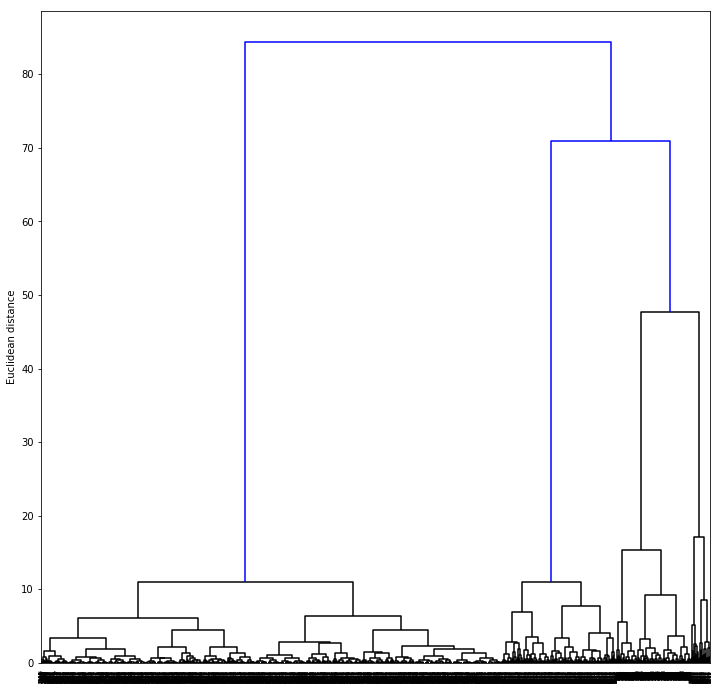

In [10]:
set_link_color_palette(['black'])
link = linkage(df_scaled, method='ward', metric='euclidean')
plt.figure(figsize=(12,12))
dnd = dendrogram(link)
plt.ylabel("Euclidean distance")
plt.show()


Looking at the above, we'd make the cut where there is the biggest gap between 2 successive combinations.  This looks to be the largest at the 20-40 distance.  This would 'cut' through 4 clusters (although it's a close call with 3 cluster possibility)... which is also the same # of clusters used in the KMeans method. 


5.)  Next we apply the Agglomerative Clustering and calculate the Silhouette score to measure how well the clustering works.  Actually because it's so close between the 3 and 4 cluster possibility, I opted to calculate the Silhouette score for both of these options to see which one this indicated did a better job.

In [11]:
model_3C = AgglomerativeClustering(n_clusters=3)
model_3C.fit(df_scaled)
silhouette_score(df_scaled, model_3C.labels_)


0.7573076255215898

In [12]:
model_4C = AgglomerativeClustering(n_clusters=4)
model_4C.fit(df_scaled)
silhouette_score(df_scaled, model_4C.labels_)

0.778897040913367

We want something as close to 1 as possible.  Since the Agglomerative Clustering model using 4 clusters as a Silhouette score closer to 1, this validates my selection of 4 clusters using this method.  Again this is the same # of clusters indcated from the KMeans clustering method.  And the fact that this value is high/fairly close to 1, this indicates that the number of clusters used is good.

6.)  Finally as one last step, going to calculate Silhouette score of KMeans clustering method and compare to the heirarchical method.

In [14]:
silhouette_score(df_scaled, km.labels_)

0.7843727073779272

Since the Silhouette score of the KMeans model is slightly closer to 1 than the heirarchical model, I would say the KMeans would do a better job at clustering (assuming # of clusters =4.)